## Table of contents

* [Loading packages](#loading_packages)
    * [Section 1.1: Excel file name explanation](#excelexplain)
    * [Section 1.2: Useful Functions](#functions)
        * [Section 1.2.1](#section_1_2_1)
        * [Section 1.2.2](#section_1_2_2)
        * [Section 1.2.3](#section_1_2_3)
* [Data import](#dataimport)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)

##### Section 1.2.1 <a class="anchor" id="section_1_2_1"></a>

##### Section 1.2.2 <a class="anchor" id="section_1_2_2"></a>

##### Section 1.2.3 <a class="anchor" id="section_1_2_3"></a>

#### Section 2.1 <a class="anchor" id="section_2_1"></a>

#### Section 2.2 <a class="anchor" id="section_2_2"></a>

### Loading packages <a class="anchor" id="loading_packages"></a>

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import timeit
import re
import os
import glob
from V4_2_Fingerprinting_Workflow_SVC_beta_version_python import fingerprintingWorkflow
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#### Excel file name explanation <a class="anchor" id="excelexplain"></a>

The attached files are direct injection IL and the following explains the file naming:
- 0220F00991
- month (02) year (20) station (009) octane (91)
Anything with a D at end is diesel and the composites are obviously a mixture of a fuel. 

#### Useful Functions <a class="anchor" id="functions"></a>

### Data import <a class="anchor" id="dataimport"></a>

https://www.mit.edu/~amidi/teaching/data-science-tools/conversion-guide/r-python-data-manipulation/

In [2]:
file_list = glob.glob(os.getcwd() + '\\CSV_Export_2023-05-23_Cleaned\\*.csv', recursive = True)

In [4]:
# isolating IL types
indi_file_list = []
for file in file_list:
    if "Blank" in file or "SampleInfo" in file:
        next
    else:
        indi_file_list.append(file)

In [5]:
# Import IL samples to list
df_list = list(map(lambda file: pd.read_csv(file, skiprows = 2), indi_file_list))

### Data distribution Pre-normalization

In [6]:
for i in range(0, len(df_list)):
#     df_list_clean[i]['Percent_Area'] = df_list_clean[i]['Area']/sum(np.array(df_list_clean[i]['Area']))
#     df_list_clean[i]['Percent_Height'] = df_list_clean[i]['Height']/sum(np.array(df_list_clean[i]['Height']))
    # Percentage-based normalization aka. Total Sum normalization
    df_list[i]['sample_name'] = indi_file_list[i].split("\\")[-1].split(".")[0] # truncate the name of the sample file name

### Grouping compounds based on Retention time

In [7]:
# Combine all subset_df together
combined_dfs1 = pd.concat(df_list, ignore_index=True)

In [8]:
# apply limit of detection (min. Area = 100000)
new_combined_dfs1 = combined_dfs1[combined_dfs1.Area > 100000]

In [9]:
center_X = np.array(new_combined_dfs1.iloc[:, 1])
new_center_X = center_X.reshape(-1, 1)

In [10]:
kmeans = KMeans(n_clusters=25, random_state=123)

In [11]:
kmeans.fit(new_center_X)

C:\Users\huyng\anaconda3\envs\arson\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=25, random_state=123)

In [12]:
clusters = kmeans.predict(new_center_X)

In [13]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [24]:
print(labels)

[ 0  0  0 ...  3  3 15]


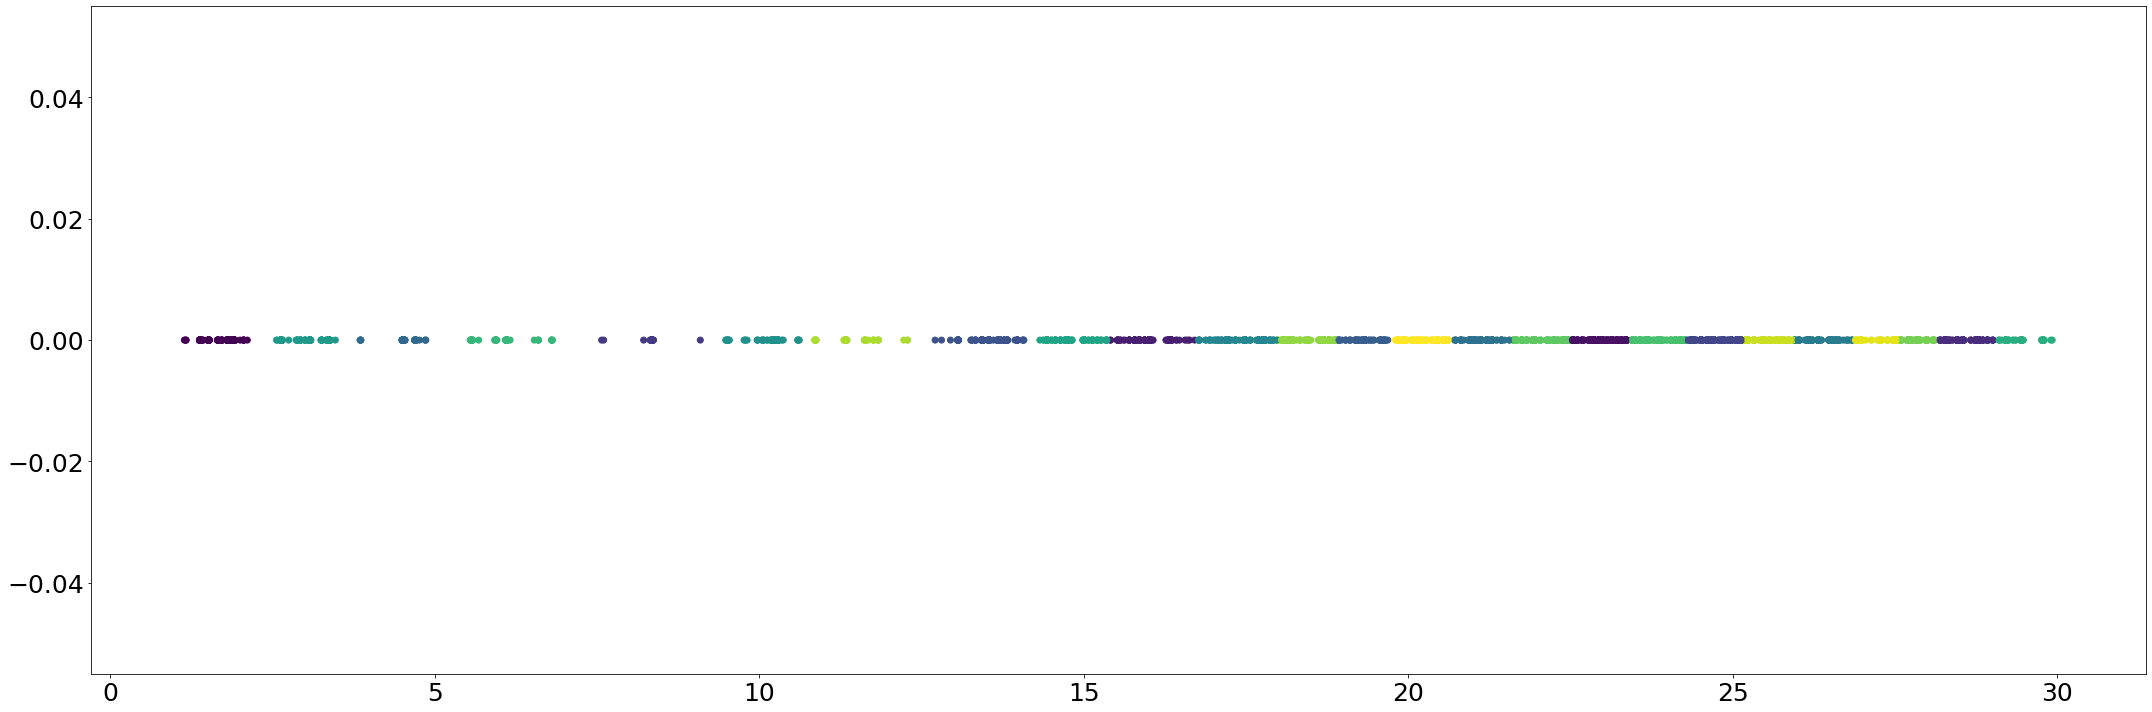

In [22]:
fig, ax = plt.subplots()
# Plot the data points and centroids
ax.scatter(new_center_X, np.zeros_like(new_center_X), c=labels)
# plt.scatter(centroids, np.zeros_like(centroids), c='red', marker='x', s=100)
# Set the x and y axis labels

# Set the tick label font size
ax.tick_params(axis='both', labelsize=25)
fig.set_size_inches(30, 10)
fig.tight_layout()
plt.show()

In [584]:
# Initialize the compound_group column filled with NA values
combined_dfs1['compound_group'] = float('nan')
i = 1

# Grouping compounds based on RT1, RT2, and Ion 1
for row in range(0, combined_dfs1.shape[0]):
    # filter data by index
    rt1 = combined_dfs1.loc[row,'RT1']
    rt2 = combined_dfs1.loc[row,'RT2']
    ion1 = combined_dfs1.loc[row,'Ion1']
    idx = combined_dfs1[(combined_dfs1.RT1 < (rt1 + 0.4)) & 
         (combined_dfs1.RT1 > (rt1 - 0.4)) &
         (combined_dfs1.RT2 < (rt2 + 0.125)) & 
         (combined_dfs1.RT2 > (rt2 - 0.125)) &
         (combined_dfs1.Ion1 < (ion1 + 0.1)) & 
         (combined_dfs1.Ion1 > (ion1 - 0.1)) &  
         (combined_dfs1.compound_group.isna())].index.values
    if np.any(idx):
        combined_dfs1.loc[idx, 'compound_group'] = "Compound_" + str(i) + "."
        i = i + 1 
    else:
        continue

### Data Normalization

### Similar Compounds found across samples

In [587]:
all_similar_compounds_idx = np.array([])
all_other_compounds_idx = np.array([])
all_unique_compounds_idx = np.array([])

for comp_grp in set(combined_dfs1['compound_group']):
    # filter data by index, ALWAYS DO THIS INSTEAD OF CREATE SUBSET DATAFRAME
    idx = combined_dfs1[combined_dfs1['compound_group'].str.contains(comp_grp, 
                                                                   flags = re.IGNORECASE, 
                                                                   regex =  False)].index.values
    
    if len(set(combined_dfs1.loc[idx, 'sample_name'])) > (len(indi_IL_file_list) - 1):
        all_similar_compounds_idx = np.append(all_similar_compounds_idx, idx)
        
    elif len(set(combined_dfs1.loc[idx, 'sample_name'])) < 2:
        all_unique_compounds_idx = np.append(all_unique_compounds_idx, idx)
        
    else:
        all_other_compounds_idx = np.append(all_other_compounds_idx, idx)

In [590]:
similar_compounds = combined_dfs1.iloc[all_similar_compounds_idx]
other_compounds = combined_dfs1.iloc[all_other_compounds_idx]
unique_compounds = combined_dfs1.iloc[all_unique_compounds_idx]